# リポジトリクローン

In [1]:
!git clone https://github.com/ctom2/colie

Cloning into 'colie'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 143 (delta 72), reused 49 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (143/143), 27.05 MiB | 60.75 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [2]:
%cd colie

/content/colie


# 照度最適化関連関数

In [3]:
import cv2
import torch
import numpy as np

from utils import (
    get_v_component,
    replace_v_component,
    interpolate_image,
    get_coords,
    get_patches,
    filter_up,
)
from siren import INF
from loss import L_exp, L_TV
from color import rgb2hsv_torch, hsv2rgb_torch

def execute_colie(
    image,
    alpha,
    beta,
    gamma,
    delta,
    L,
    window,
    epochs,
    down_size,
):
    # モデル生成
    siren_model = INF(
        patch_dim=window**2,
        num_layers=4,
        hidden_dim=256,
        add_layer=2,
    )
    siren_model.cuda()

    # オプティマイザー準備
    optimizer = torch.optim.Adam(
        siren_model.parameters(),
        lr=1e-5,
        betas=(0.9, 0.999),
        weight_decay=3e-4,
    )
    # 前処理
    hsv_image, v_image, v_image_lr, coords, patches = preprocess(
        image,
        down_size,
        window,
    )

    # 照度最適化
    l_exp = L_exp(16, L)
    l_tv = L_TV()
    for epoch in range(epochs):
        siren_model.train()
        optimizer.zero_grad()

        illu_res_lr = siren_model(patches, coords)
        illu_res_lr = illu_res_lr.view(1, 1, down_size, down_size)
        illu_lr = illu_res_lr + v_image_lr

        v_image_fixed_lr = (v_image_lr) / (illu_lr + 1e-4)

        loss_spa = torch.mean(torch.abs(torch.pow(illu_lr - v_image_lr, 2)))
        loss_tv = l_tv(illu_lr)
        loss_exp = torch.mean(l_exp(illu_lr))
        loss_sparsity = torch.mean(v_image_fixed_lr)

        loss = loss_spa * alpha + loss_tv * beta + loss_exp * gamma + loss_sparsity * delta
        loss.backward()
        optimizer.step()

    v_image_fixed = filter_up(v_image_lr, v_image_fixed_lr, v_image)
    hsv_image_fixed = replace_v_component(hsv_image, v_image_fixed)
    rgb_image_fixed = hsv2rgb_torch(hsv_image_fixed)
    rgb_image_fixed = rgb_image_fixed / torch.max(rgb_image_fixed)

    # 後処理
    result_image = postprocess(rgb_image_fixed)

    return result_image

def preprocess(image, down_size, window):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rgb_image = torch.from_numpy(rgb_image).float() / 255.0
    rgb_image = rgb_image.permute(2, 0, 1).unsqueeze(0).cuda()
    hsv_image = rgb2hsv_torch(rgb_image)

    v_image = get_v_component(hsv_image)
    v_image_lr = interpolate_image(v_image, down_size, down_size)
    coords = get_coords(down_size, down_size)
    patches = get_patches(v_image_lr, window)

    return hsv_image, v_image, v_image_lr, coords, patches

def postprocess(rgb_image_fixed):
    rgb_image_fixed = rgb_image_fixed.detach().cpu().numpy()
    rgb_image_fixed = np.clip(rgb_image_fixed, 0, 1) * 255.0
    rgb_image_fixed = rgb_image_fixed.astype(np.uint8)
    rgb_image_fixed = rgb_image_fixed[0].transpose(1, 2, 0)
    result_image = cv2.cvtColor(rgb_image_fixed, cv2.COLOR_RGB2BGR)

    return result_image

# CoLIE実行

### サンプル画像ダウンロード

In [4]:
# https://www.pakutaso.com/20240513145post-51368.html
!wget https://user0514.cdnw.net/shared/img/thumb/jyujyutukaisenDSC00683_TP_V4.jpg -O test.jpg

--2024-09-07 01:37:50--  https://user0514.cdnw.net/shared/img/thumb/jyujyutukaisenDSC00683_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 172.233.81.82
Connecting to user0514.cdnw.net (user0514.cdnw.net)|172.233.81.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41200 (40K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  40.23K   168KB/s    in 0.2s    

2024-09-07 01:37:51 (168 KB/s) - ‘test.jpg’ saved [41200/41200]



In [5]:
import time

# 画像読み込み
image = cv2.imread('test.jpg')

# パラメータ
alpha = 1       # 忠実度コントロール (デフォルト: 1)
beta = 20       # 照明の滑らかさ（デフォルト: 20）
gamma = 8       # 露出制御（デフォルト: 8）
delta = 5       # スパースレベル（デフォルト: 5）
L = 0.3         # 最適強度閾値 ※値が低いほど明るい画像
window = 1      # コンテキストウィンドウサイズ
epochs = 100    # 最適化ステップ数
down_size = 256 # ダウンサンプリングサイズ

start_time = time.time()

# CoLIE実行
result_image = execute_colie(
    image,
    alpha,
    beta,
    gamma,
    delta,
    L,
    window,
    epochs,
    down_size,
)

elapsed_time = time.time() - start_time

text = 'Elapsed Time: %.0fms ' % (elapsed_time * 1000)
print(text)

Elapsed Time: 6913ms 


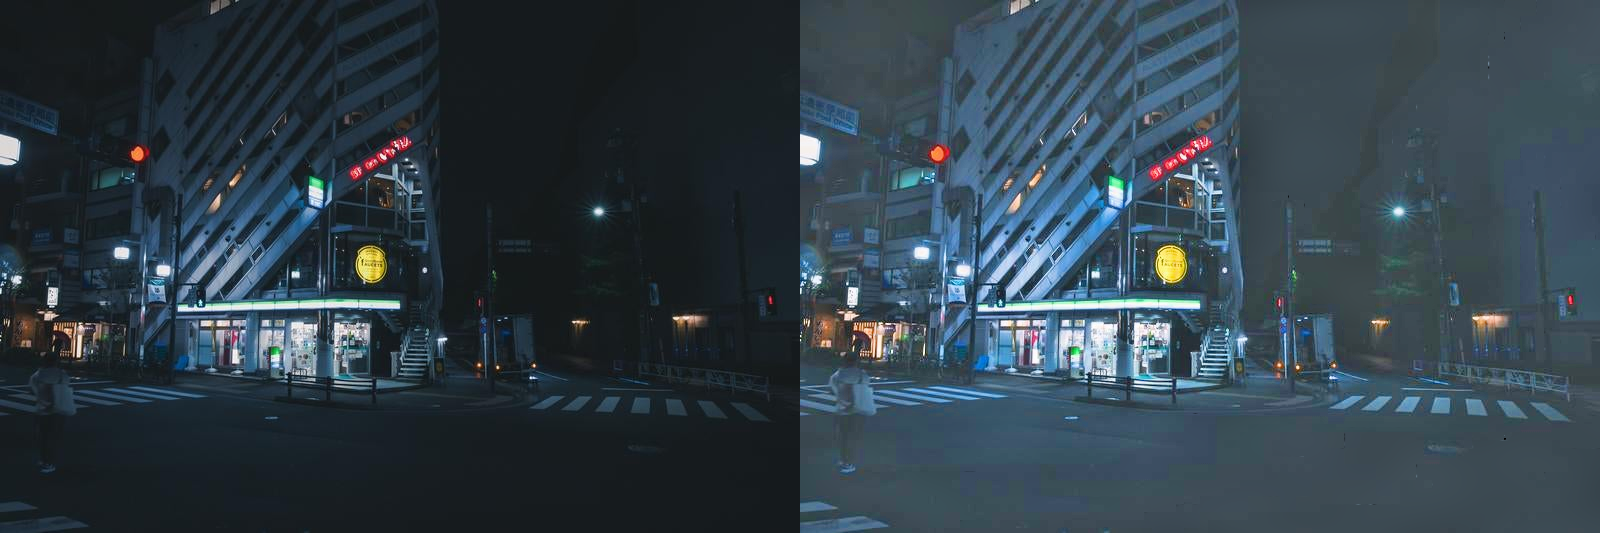

In [6]:
import cv2
from google.colab.patches import cv2_imshow

concat_image = cv2.hconcat([image, result_image])
cv2_imshow(concat_image)

### サンプル動画ダウンロード

In [7]:
# 夜の淀川に浮かぶ屋形船[https://www2.nhk.or.jp/archives/movies/?id=D0002020004_00000]
!wget https://www.nhk.or.jp/das/movie/D0002020/D0002020004_00000_V_000.mp4 -q -O sample.mp4

In [8]:
# 8秒位置から10秒間切り出し、10fpsの動画に変換
!ffmpeg -loglevel quiet -ss 8 -t 10 -i sample.mp4 -c:v libx264 -r 10 -c:a copy test.mp4

In [10]:
import time
import copy
from tqdm import tqdm

# 動画読み込み
cap = cv2.VideoCapture('test.mp4')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 動画書き込み設定
concat_mode = 'h'
if concat_mode == 'h':
    video_size = (int(width * 2), int(height))
elif concat_mode == 'v':
    video_size = (int(width), int(height * 2))
video_writer = cv2.VideoWriter(
    'output.mp4',
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    video_size,
)

# パラメータ
alpha = 1       # 忠実度コントロール (デフォルト: 1)
beta = 20       # 照明の滑らかさ（デフォルト: 20）
gamma = 8       # 露出制御（デフォルト: 8）
delta = 5       # スパースレベル（デフォルト: 5）
L = 0.3         # 最適強度閾値 ※値が低いほど明るい画像
window = 1      # コンテキストウィンドウサイズ
epochs = 100    # 最適化ステップ数
down_size = 256 # ダウンサンプリングサイズ

with tqdm(total=total_frames, desc="Processing Video") as pbar:
    while True:
        start_time = time.time()

        # フレーム読み出し
        ret, frame = cap.read()
        if not ret:
            print('break')
            break

        # CoLIE実行
        result_image = execute_colie(
            frame,
            alpha,
            beta,
            gamma,
            delta,
            L,
            window,
            epochs,
            down_size,
        )

        elapsed_time = time.time() - start_time

        # 処理時間描画
        text = 'Elapsed Time: %.0fms ' % (elapsed_time * 1000)
        cv2.putText(
            result_image,
            text,
            (30, 30),
            cv2.FONT_HERSHEY_PLAIN,
            1.5,
            (0, 255, 0),
            thickness=1,
        )
        if concat_mode == 'h':
            write_image = cv2.hconcat([frame, result_image])
        elif concat_mode == 'v':
            write_image = cv2.vconcat([frame, result_image])
        # 動画書き込み
        video_writer.write(write_image)

        pbar.update(1)
    video_writer.release()

Processing Video: 100%|██████████| 102/102 [05:28<00:00,  3.22s/it]

break
